In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
# from tqdm.notebook import tqdm
from tqdm import tqdm
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime, timedelta
from shapely.geometry import Point
from shapely.strtree import STRtree
import utm
import glob
import os
import time
import pandas as pd
import pyarrow.parquet as pq
import geopandas as gpd
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import geopandas as gpd
import multiprocessing
import os
import sys
import numpy
from pyproj import Transformer
import argparse
from itertools import chain
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pyproj
import h3pandas
from sklearn.metrics import confusion_matrix

# read xovers

In [287]:
xovers = pd.read_parquet('/gpfs/data1/vclgp/aghdamim/LVIS/crossover/Michelle/GEDI_LVIS_xovers_closest_oct23.parquet')
print(len(xovers))
xovers['gedi_sn'] = xovers['gedi_sn'].astype('uint64')
xovers['lvis_shot_id'] = xovers['lvis_lfid'].astype(str) + xovers['lvis_sn'].astype(str)
xovers['gedi_lon'] = (xovers['gedi_lon'] + 180) % 360 - 180
xovers['lvis_lon'] = (xovers['lvis_lon'] + 180) % 360 - 180
xovers = gpd.GeoDataFrame(xovers, geometry=gpd.points_from_xy(xovers['gedi_lon'], xovers['gedi_lat']), crs="EPSG:4326")
xovers = xovers.h3.geo_to_h3(12).h3.h3_to_parent(3)
xovers

675865


,gedi_sn,gedi_lon,gedi_lat,u1,lvis_lfid,lvis_sn,lvis_lon,lvis_lat,u2,lvis_shot_id,geometry,h3_03
h3_12,,,,,,,,,,,,
8c26c10b662e3ff,18350600300692465,-97.901740,35.205134,330.245,1658624219,14617110,-97.901829,35.205158,330.794,165862421914617110,POINT (-97.90174 35.20513),8326c1fffffffff
8c26c10b66745ff,18350600300692467,-97.900820,35.204431,327.624,1658624219,14617643,-97.900768,35.204394,327.383,165862421914617643,POINT (-97.90082 35.20443),8326c1fffffffff
8c26c10b66755ff,18350600300692468,-97.900359,35.204079,328.336,1658624219,14617899,-97.900340,35.204033,328.207,165862421914617899,POINT (-97.90036 35.20408),8326c1fffffffff
8c26c10b6644bff,18350600300692470,-97.899439,35.203377,329.040,1658624219,14618293,-97.899342,35.203409,328.910,165862421914618293,POINT (-97.89944 35.20338),8326c1fffffffff
8c26c10b292b7ff,18350600300692479,-97.895297,35.200217,331.916,1658624219,14620053,-97.895225,35.200276,331.534,165862421914620053,POINT (-97.89530 35.20022),8326c1fffffffff
...,...,...,...,...,...,...,...,...,...,...,...,...
8c82a112061b1ff,241121100100058077,13.319690,-1.420531,344.086,1657441070,4613048,13.319708,-1.420557,344.040,16574410704613048,POINT (13.31969 -1.42053),8382a1fffffffff
8c82a11206f65ff,241121100100058079,13.320283,-1.419694,326.747,1657441070,4613485,13.320257,-1.419662,327.010,16574410704613485,POINT (13.32028 -1.41969),8382a1fffffffff
8c82a1123d349ff,241121100100058084,13.321767,-1.417602,286.595,1657441070,4614803,13.321783,-1.417605,287.250,16574410704614803,POINT (13.32177 -1.41760),8382a1fffffffff


In [288]:
print(len(xovers[xovers['lvis_shot_id'].duplicated(keep=False)]))
print(len(xovers[xovers['gedi_sn'].duplicated(keep=False)]))

21746
0


In [289]:
def parallel_run(h3):
    temp_df = pd.read_parquet(f'/gpfs/data1/vclgp/data/iss_gedi/h3/ancillary/nasa_dem/{h3}.parquet')
    return temp_df[temp_df['shot_number'].isin(xovers['gedi_sn'].values)]

h3_list = xovers.h3_03.unique()
nasa_dem = []
n_cpus = 20
pool = multiprocessing.Pool(n_cpus)
for temp_df in tqdm(pool.imap_unordered(parallel_run, h3_list), total=len(h3_list), position=0):
    nasa_dem.append(temp_df)
pool.close()
nasa_dem = pd.concat(nasa_dem, ignore_index=True)

100%|███████████████████████████████████████████████| 369/369 [01:02<00:00,  5.90it/s]


In [290]:
nasa_dem

,shot_number,relative_pixel_distance,elevation,slope,aspect,water_mask,elevation_mean_3x3,slope_mean_3x3,water_mask_sum_3x3
0,18500100300228598,0.117468,84.0,3.390155,254.141403,0.0,83.888885,3.145656,0.0
1,18500100300228634,0.361041,66.0,1.429504,229.557434,0.0,65.222221,1.327188,0.0
2,18500200300236718,0.196397,94.0,3.750222,60.401047,0.0,92.888885,4.367736,0.0
3,18500200300236780,0.246039,88.0,2.857338,310.440735,0.0,87.333336,3.300225,0.0
4,18500200300236784,0.314112,81.0,2.149611,149.602234,0.0,80.333336,1.516124,0.0
...,...,...,...,...,...,...,...,...,...
674140,70090100300183427,0.430194,2021.0,10.194938,8.049187,0.0,2019.555542,12.012489,0.0
674141,70090200300188846,0.222025,2150.0,30.162899,265.206512,0.0,2143.444336,32.906303,0.0
674142,179430500300360159,0.343827,2145.0,37.236805,63.431866,0.0,2145.111084,39.002750,0.0
674143,99360300300165477,0.218954,545.0,0.000000,-0.000000,0.0,545.000000,1.197623,0.0


In [60]:
# nasa_dem.to_parquet('nasa_dem.parquet')

# read gedi/lvis

In [291]:
LVIS = pd.read_parquet('/gpfs/data1/vclgp/aghdamim/LVIS/crossover/Michelle/LVIS.parquet')
print(len(LVIS))
LVIS = pd.merge(LVIS, xovers[['gedi_sn', 'lvis_shot_id']], on='lvis_shot_id', how='inner')
print(len(LVIS))

590506
600636


In [292]:
GEDI_L2A = pd.read_parquet('/gpfs/data1/vclgp/aghdamim/LVIS/crossover/Michelle/GEDI_L2A.parquet')
print(len(GEDI_L2A))
GEDI_L1B = pd.read_parquet('/gpfs/data1/vclgp/aghdamim/LVIS/crossover/Michelle/GEDI_L1B.parquet')
print(len(GEDI_L1B))

674088
620995


In [293]:
common_sn = np.intersect1d(LVIS['gedi_sn'].values, GEDI_L2A['shot_number'].values)
common_sn = np.intersect1d(common_sn, GEDI_L1B['shot_number'].values)
common_sn = np.intersect1d(common_sn, nasa_dem['shot_number'].values)

GEDI_L2A_df = GEDI_L2A.copy()
GEDI_L2A_df = GEDI_L2A_df[GEDI_L2A_df['shot_number'].isin(common_sn)]
GEDI_L2A_df = GEDI_L2A_df.sort_values(by='shot_number')
GEDI_L2A_df = GEDI_L2A_df.reset_index(drop=True)

GEDI_L1B_df = GEDI_L1B.copy()
GEDI_L1B_df = GEDI_L1B_df[GEDI_L1B_df['shot_number'].isin(common_sn)]
GEDI_L1B_df = GEDI_L1B_df.sort_values(by='shot_number')
GEDI_L1B_df = GEDI_L1B_df.reset_index(drop=True)

LVIS_df = LVIS.copy()
LVIS_df = LVIS_df[LVIS_df['gedi_sn'].isin(common_sn)]
LVIS_df = LVIS_df.sort_values(by='gedi_sn')
LVIS_df = LVIS_df.reset_index(drop=True)

NASA_DEM_df = nasa_dem.copy()
NASA_DEM_df = NASA_DEM_df[NASA_DEM_df['shot_number'].isin(common_sn)]
NASA_DEM_df = NASA_DEM_df.sort_values(by='shot_number')
NASA_DEM_df = NASA_DEM_df.reset_index(drop=True)

In [294]:
print(np.array_equal(GEDI_L2A_df['shot_number'].values, GEDI_L1B_df['shot_number'].values))
print(np.array_equal(GEDI_L2A_df['shot_number'].values, LVIS_df['gedi_sn'].values))
print(np.array_equal(LVIS_df['gedi_sn'].values, NASA_DEM_df['shot_number'].values))
print(len(LVIS_df), len(GEDI_L1B_df), len(GEDI_L2A_df), len(NASA_DEM_df))

True
True
True
549082 549082 549082 549082


In [295]:
def select_GEDI_L2A_alg(GEDI_L2A_df, algorithm='1'):
    alg_cols = [col for col in GEDI_L2A_df.columns if any(suffix in col for suffix in ['_a1', '_a2', '_a5', '_a10'])]
    alg_cols = pd.Series(alg_cols).str.replace(r'_a[125]0?', '_a{}', regex=True).unique()
    same_cols = [col for col in GEDI_L2A_df.columns if not any(suffix in col for suffix in ['_a1', '_a2', '_a5', '_a10'])]
    extra_cols = []# ['rx_processing_a2/rx_algrunflag', 'rx_processing_a2/zcross', 'rx_processing_a2/toploc', 'geolocation/sensitivity_a1']
    
    GEDI_L2A_df2 = GEDI_L2A_df[same_cols+extra_cols].copy()
    for alg_col in alg_cols:
        if algorithm=='selected':
            column_list = []
            for i, alg in enumerate(GEDI_L2A_df['selected_algorithm'].values):
                column_list.append(GEDI_L2A_df[alg_col.format(alg)].values[i])
        else:
            column_list = GEDI_L2A_df[alg_col.format(algorithm)].values
        GEDI_L2A_df2[alg_col.replace('_a{}', '')] = column_list
    return GEDI_L2A_df2

In [296]:
GEDI_L2A_df_alg = select_GEDI_L2A_alg(GEDI_L2A_df, algorithm='selected')
GEDI_L2A_df_alg.columns

Index(['beam', 'channel', 'degrade_flag', 'delta_time',
       'digital_elevation_model', 'digital_elevation_model_srtm',
       'elevation_bias_flag', 'geolocation/stale_return_flag',
       'land_cover_data/landsat_treecover',
       'land_cover_data/landsat_water_persistence',
       'land_cover_data/leaf_off_flag', 'land_cover_data/pft_class',
       'land_cover_data/region_class', 'land_cover_data/urban_proportion',
       'rx_assess/mean', 'rx_assess/mean_64kadjusted',
       'rx_assess/quality_flag', 'rx_assess/rx_assess_flag',
       'rx_assess/rx_energy', 'rx_assess/rx_maxamp', 'rx_assess/sd_corrected',
       'selected_algorithm', 'selected_mode', 'shot_number', 'solar_azimuth',
       'solar_elevation', 'surface_flag', 'geolocation/elev_highestreturn',
       'geolocation/elev_lowestmode', 'geolocation/elev_lowestreturn',
       'geolocation/lat_highestreturn', 'geolocation/lat_lowestmode',
       'geolocation/lat_lowestreturn', 'geolocation/lon_highestreturn',
       'geolo

In [297]:
print(np.array_equal(GEDI_L2A_df['shot_number'].values, GEDI_L2A_df_alg['shot_number'].values))

True


# residuals

In [298]:
rh98_residual = GEDI_L2A_df_alg['geolocation/rh_98'].values/100 -  LVIS_df['RH98'].values
ctop_residuals = GEDI_L2A_df_alg['geolocation/elev_highestreturn'].values - LVIS_df['ZT'].values
ground_residuals = GEDI_L2A_df_alg['geolocation/elev_lowestmode'].values - LVIS_df['ZG'].values

In [299]:
rmse = np.sqrt(mean_squared_error(GEDI_L2A_df_alg['geolocation/elev_lowestmode'].values, LVIS_df['ZG'].values))
rmse

2.634643199436754

# calculate correlation

In [300]:
def query_gedi_by_index(gedi_ind, GEDI_L2A_df_alg, GEDI_L1B_df):
    shot_number = GEDI_L2A_df_alg['shot_number'].iloc[gedi_ind]
    elev_lowestmode = GEDI_L2A_df_alg['geolocation/elev_lowestmode'].iloc[gedi_ind]
    elev_highestreturn = GEDI_L2A_df_alg['geolocation/elev_highestreturn'].iloc[gedi_ind]
    wfCount = GEDI_L1B_df['rx_sample_count'].iloc[gedi_ind]
    waveform = GEDI_L1B_df['rxwaveform'].iloc[gedi_ind][:wfCount]
    elev_bin0 = GEDI_L1B_df['geolocation/elevation_bin0'].iloc[gedi_ind]
    elev_lastbin = GEDI_L1B_df['geolocation/elevation_lastbin'].iloc[gedi_ind] 
    zstretch = np.add(elev_lastbin, np.multiply(range(wfCount,0,-1), ((elev_bin0-elev_lastbin) / int(wfCount-1))))
    return [shot_number, wfCount, elev_lowestmode, elev_highestreturn, elev_bin0, elev_lastbin, waveform, zstretch]
    

def query_lvis_by_index(lvis_ind, LVIS_df):
    SN = LVIS_df['SHOTNUMBER'].iloc[lvis_ind]
    LFID = LVIS_df['LFID'].iloc[lvis_ind]
    ZG = LVIS_df['ZG'].iloc[lvis_ind]
    ZT = LVIS_df['ZT'].iloc[lvis_ind]
    waveform = LVIS_df['RXWAVE'].iloc[lvis_ind]
    wfCount = len(waveform)
    Z0 = LVIS_df['Z0'].iloc[lvis_ind]
    Z1023 = LVIS_df['Z1023'].iloc[lvis_ind]
    zstretch = np.add(Z1023, np.multiply(range(wfCount, 0, -1),((Z0 - Z1023)/int(wfCount - 1))))
    return [SN, LFID, ZG, ZT, Z0, Z1023, waveform, zstretch]

In [354]:
def get_correlation(ind, LVIS_df, GEDI_L2A_df_alg, GEDI_L1B_df, slide=4, show=False):
    [shot_number, wfCount, gedi_elev_lowestmode, gedi_elev_highestreturn, 
         gedi_elev_bin0, gedi_elev_lastbin, gedi_wf, gedi_zstretch] = query_gedi_by_index(ind, GEDI_L2A_df_alg, GEDI_L1B_df)
    [SN, LFID, lvis_ZG, lvis_ZT, lvis_Z0, lvis_Z1023, lvis_wf, lvis_zstretch] = query_lvis_by_index(ind, LVIS_df)
    
    ctop_value = np.max([lvis_ZT, gedi_elev_highestreturn])+2
    grd_value = np.min([lvis_ZG, gedi_elev_lowestmode])-2
    final_correlation = 0
    final_dy = 0
    if gedi_elev_bin0>=ctop_value and lvis_Z0>=ctop_value and gedi_elev_lastbin<=grd_value and lvis_Z1023<=grd_value:
        gedi_ctop_ind = np.argmin(np.abs(gedi_zstretch-ctop_value))
        gedi_grd_ind = np.argmin(np.abs(gedi_zstretch-grd_value))
        gedi_clip = gedi_wf[gedi_ctop_ind:gedi_grd_ind]
        lvis_ctop_ind = np.argmin(np.abs(lvis_zstretch-ctop_value))
        lvis_grd_ind = np.argmin(np.abs(lvis_zstretch-grd_value))
        lvis_clip = lvis_wf[lvis_ctop_ind:lvis_grd_ind]
        min_len = np.min([len(gedi_clip), len(lvis_clip)])

        subbin_res = 1
        gedi_ss = np.interp(np.arange(min_len*subbin_res)/subbin_res, np.arange(min_len), gedi_clip[:min_len])
        lvis_ss = np.interp(np.arange(min_len*subbin_res)/subbin_res, np.arange(min_len), lvis_clip[:min_len])
        # gedi_ss = gaussian_filter1d(gedi_ss, sm*subbin_res)
        # lvis_ss = gaussian_filter1d(lvis_ss, sm*subbin_res)

        final_correlation = np.corrcoef(gedi_ss, lvis_ss)[0, 1]**2
        for dy in list(range(-slide, 0))+list(range(1, slide+1)):
            if dy>0:  
                correlation = np.corrcoef(gedi_ss[dy:], lvis_ss[:-dy])[0, 1]**2
            elif dy<0:
                correlation = np.corrcoef(gedi_ss[:dy], lvis_ss[-dy:])[0, 1]**2
            if correlation>final_correlation:
                final_correlation = correlation
                final_dy = dy

    if show:
        gedi_ss = (gedi_ss - gedi_ss.min())/(gedi_ss.max() - gedi_ss.min())
        lvis_ss = (lvis_ss - lvis_ss.min())/(lvis_ss.max() - lvis_ss.min())
        plt.figure()
        plt.title(f'dy= {final_dy}')
        if final_dy==0:
            plt.plot(gedi_ss, label='gedi')
            plt.plot(lvis_ss, label='lvis')
        elif final_dy>0:
            plt.plot(gedi_ss[final_dy:], label='gedi')
            plt.plot(lvis_ss[:-final_dy], label='lvis')
        elif final_dy<0:
            plt.plot(gedi_ss[:final_dy], label='gedi')
            plt.plot(lvis_ss[-final_dy:], label='lvis')
        plt.legend()
        plt.show()
    return final_correlation, final_dy

In [343]:
def parallel_run(ind):
    correlation, dy = get_correlation(ind, LVIS_df, GEDI_L2A_df_alg, GEDI_L1B_df, slide=20)
    return [ind, correlation, dy]

correlations = []
n_cpus = 30
pool = multiprocessing.Pool(n_cpus)
for correlation in tqdm(pool.imap_unordered(parallel_run, list(range(len(LVIS_df)))), total=len(LVIS_df), position=0):
    correlations.append(correlation)
pool.close()
correlations = np.array(correlations)
args = np.argsort(correlations[:, 0])
correlations = correlations[args]

100%|███████████████████████████████████████| 549082/549082 [01:21<00:00, 6711.57it/s]


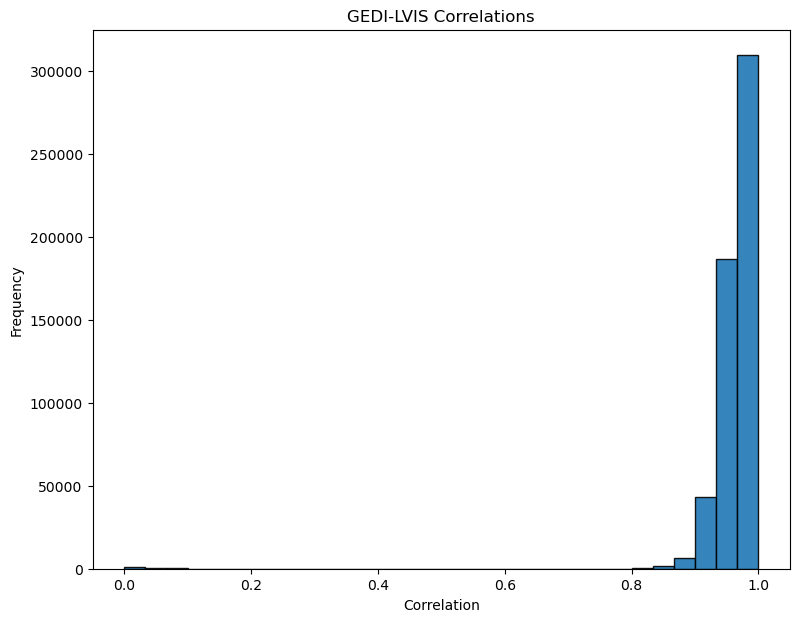

In [344]:
plt.figure(figsize=(9, 7))
plt.title('GEDI-LVIS Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.hist(correlations[:, 1], bins=30, alpha=0.9, histtype="bar", edgecolor="black")
plt.show()

# filter data

In [360]:
mask = correlations[:, 1]>0.8
mask2 = (GEDI_L2A_df_alg['geolocation/num_detectedmodes']==1) * (GEDI_L2A_df_alg['geolocation/rh_98']<500) * (np.abs(ground_residuals)<2)
mask[mask2] = False
# mask = np.logical_and(correlations[:, 1]>0.9, np.abs(correlations[:, 2])<17)

GEDI_L2A_df_masked = GEDI_L2A_df[mask]
GEDI_L2A_df_alg_masked = GEDI_L2A_df_alg[mask]
GEDI_L1B_df_masked = GEDI_L1B_df[mask]
LVIS_df_masked = LVIS_df[mask]
NASA_DEM_df_masked = NASA_DEM_df[mask]
correlations_masked = correlations[mask]
print(len(correlations_masked))

124586


In [361]:
rh98_residual_masked = GEDI_L2A_df_alg_masked['geolocation/rh_98'].values/100 -  LVIS_df_masked['RH98'].values
ctop_residuals_masked = GEDI_L2A_df_alg_masked['geolocation/elev_highestreturn'].values - LVIS_df_masked['ZT'].values
ground_residuals_masked = GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values - LVIS_df_masked['ZG'].values

In [362]:
rmse_masked = np.sqrt(mean_squared_error(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values, LVIS_df_masked['ZG'].values))
rmse_masked

3.809037054414056

# find ground bin

In [332]:
def get_ground_elev(ind, LVIS_df_masked, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked, correlations_masked, plot=False):
    dy = int(correlations_masked[ind, 2])
    # print(dy)
    [shot_number, wfCount, gedi_elev_lowestmode, gedi_elev_highestreturn, 
         gedi_elev_bin0, gedi_elev_lastbin, gedi_wf, gedi_zstretch] = query_gedi_by_index(ind, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked)
    [SN, LFID, lvis_ZG, lvis_ZT, lvis_Z0, lvis_Z1023, lvis_wf, lvis_zstretch] = query_lvis_by_index(ind, LVIS_df_masked)

    gedi_elev_bin0 += (dy*0.1498)
    lvis_grd_elev = lvis_ZG - gedi_elev_bin0
    # print(lvis_grd_elev)
    gedi_grd_elev = gedi_elev_lowestmode - gedi_elev_bin0
    

    if plot:
        plt.figure(figsize=(8, 10))
        plt.plot(gedi_wf, gedi_zstretch-gedi_elev_bin0, label='GEDI')
        plt.axhline(y = gedi_grd_elev, color = 'b', label='GEDI ground', linewidth=0.9)
        plt.axhline(y = lvis_grd_elev, color = 'g', label='LVIS ground', linewidth=0.9)
        plt.legend()
        plt.show()

    return lvis_grd_elev

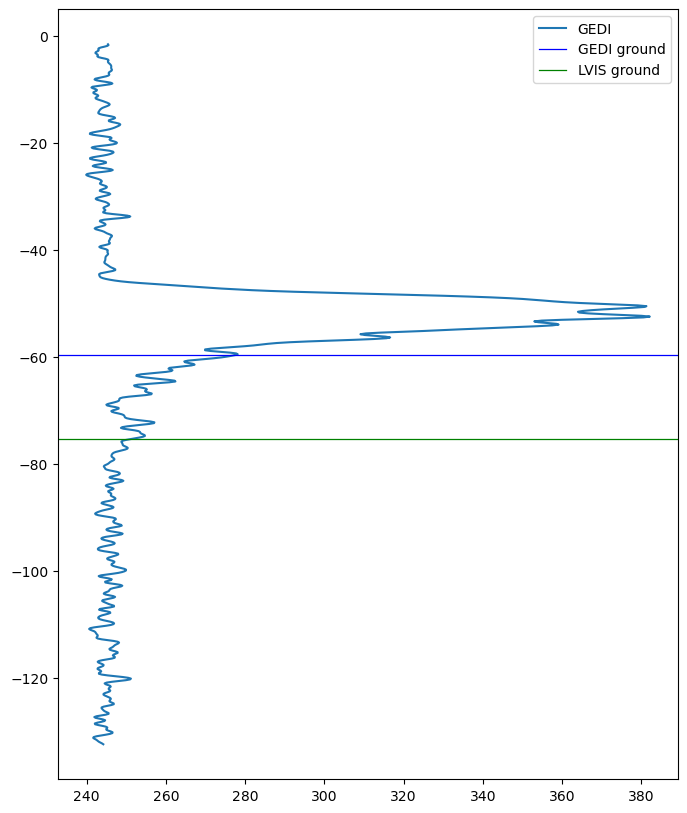

-75.31146462275382

In [333]:
get_ground_elev(np.argsort(ground_residuals_masked)[-1000], LVIS_df_masked, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked, correlations_masked, plot=True)

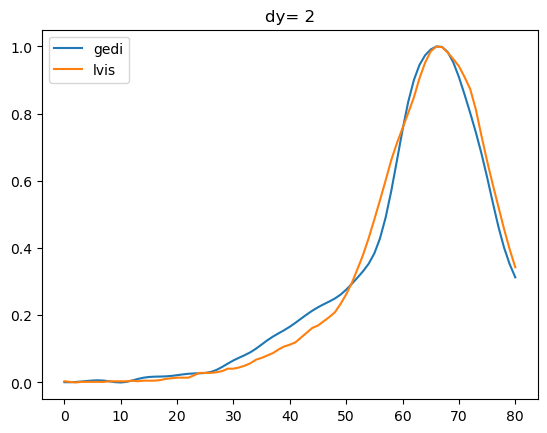

(0.987270456653112, 2)

In [359]:
get_correlation(65418, LVIS_df_masked, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked, slide=20, show=True)

In [400]:
def plot_wf(ind, LVIS_df_masked, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked, shap_inds=[], line_elev=None):
    [shot_number, wfCount, elev_lowestmode, elev_highestreturn, elev_bin0, elev_lastbin, gedi_wf, gedi_zstretch] = query_gedi_by_index(ind, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked)
    [SN, LFID, ZG, ZT, Z0, Z1023, lvis_wf, lvis_zstretch] = query_lvis_by_index(ind, LVIS_df_masked)
    print('gedi sn: ', shot_number)
    print('lvis sn: ', SN)
    print('lvis lfid: ', LFID)
    print('gedi elev lowest mode: ', elev_lowestmode)
    # print('dist1: ', distances_1[ind])
    # print('dist2: ', distances_2[ind])

    fig = plt.figure(figsize=(8, 10))
    alpha_value = 0.9
    # compare
    figplot = fig.add_subplot(111) 
    plt.ylabel('elevation(m)')
    plt.xlabel('amplitude')
    
    figplot.plot((lvis_wf-np.min(lvis_wf))/(np.max(lvis_wf)-np.min(lvis_wf)), lvis_zstretch, label='LVIS waveform')
    plt.axhline(y = ZG, color = 'b', label='LVIS ground', linewidth=0.9, alpha=alpha_value)
    # plt.axhline(y = ZT, color = 'b', linestyle='--', label='LVIS highest return', linewidth=0.9, alpha=alpha_value)

    gedi_wf = 1+((gedi_wf-np.min(gedi_wf))/(np.max(gedi_wf)-np.min(gedi_wf)))
    figplot.plot(gedi_wf, gedi_zstretch, 'grey', label='GEDI waveform')
    plt.axhline(y = elev_lowestmode, color = 'k', label='GEDI ground', linewidth=0.9, alpha=alpha_value)
    # plt.axhline(y = elev_highestreturn, color = 'k', linestyle='--', label='GEDI highest return', linewidth=0.9, alpha=alpha_value)
    # plt.savefig('plots/wf6.png', dpi=300, bbox_inches='tight')

    if len(shap_inds)>0: 
        plt.plot(gedi_wf[shap_inds], gedi_zstretch[shap_inds], 'ro', markersize=2.5)
    if line_elev:
        plt.axhline(y = elev_bin0-line_elev, color = 'r', label='Predicted ground', linewidth=0.9, alpha=alpha_value)
    plt.legend()
    plt.title('ctop_res(m)={:.2f},   grd_res(m)={:.2f},   rh98_res(m)={:.2f}'.format(ctop_residuals[ind], ground_residuals[ind], rh98_residual[ind]))
    plt.show()

gedi sn:  232120500100057465
lvis sn:  9109831
lvis lfid:  1657440139


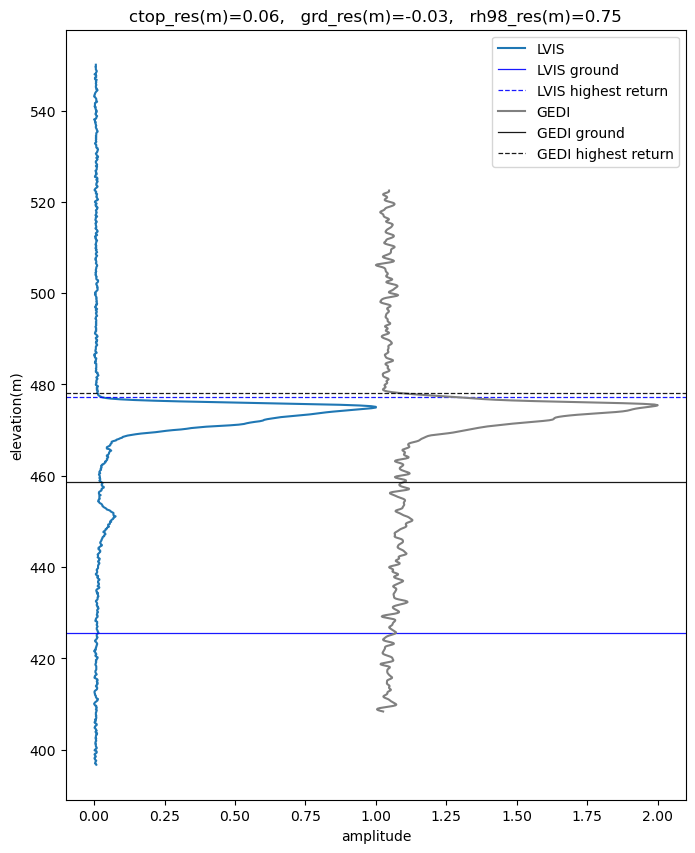

In [35]:
plot_wf(np.argsort(ground_residuals_masked)[-10], LVIS_df_masked, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked)

# create training data

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [363]:
X_data = []
for gedi_wf, sample_count in tqdm(zip(GEDI_L1B_df_masked['rxwaveform'].values, GEDI_L1B_df_masked['rx_sample_count'].values), position=0, total=len(GEDI_L1B_df_masked)):
    gedi_wf = gedi_wf[:sample_count]
    gedi_wf = (gedi_wf - gedi_wf.min())/(gedi_wf.max() - gedi_wf.min())
    temp = np.zeros(1420)
    temp[:sample_count] = gedi_wf
    X_data.append(temp)
X_data = np.array(X_data)
X_data.shape

100%|██████████████████████████████████████| 124586/124586 [00:04<00:00, 31041.98it/s]


(124586, 1420)

In [366]:
X2_data = NASA_DEM_df_masked[['relative_pixel_distance', 'elevation', 'slope', 'aspect', 'elevation_mean_3x3', 'slope_mean_3x3']].to_numpy()
X2_data.shape

(124586, 6)

In [367]:
data_inds = np.arange(X2_data.shape[0])
data_inds.shape

(124586,)

In [368]:
Y_data = []
for ind in tqdm(range(len(GEDI_L1B_df_masked)), position=0, total=len(GEDI_L1B_df_masked)):
    Y_data.append(get_ground_elev(ind, LVIS_df_masked, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked, correlations_masked, plot=False))
Y_data = np.array(Y_data)
Y_data = np.abs(Y_data)# / (1420*0.15)
Y_data.shape

100%|███████████████████████████████████████| 124586/124586 [00:36<00:00, 3412.57it/s]


(124586,)

In [381]:
np.save('data/Y_data.npy', Y_data)
np.save('data/X2_data.npy', X2_data)
np.save('data/X_data.npy', X_data)
np.save('data/data_inds.npy', data_inds)

gedi sn:  25681100300212369
lvis sn:  5434921
lvis lfid:  1658632081
gedi elev lowest mode:  918.81085


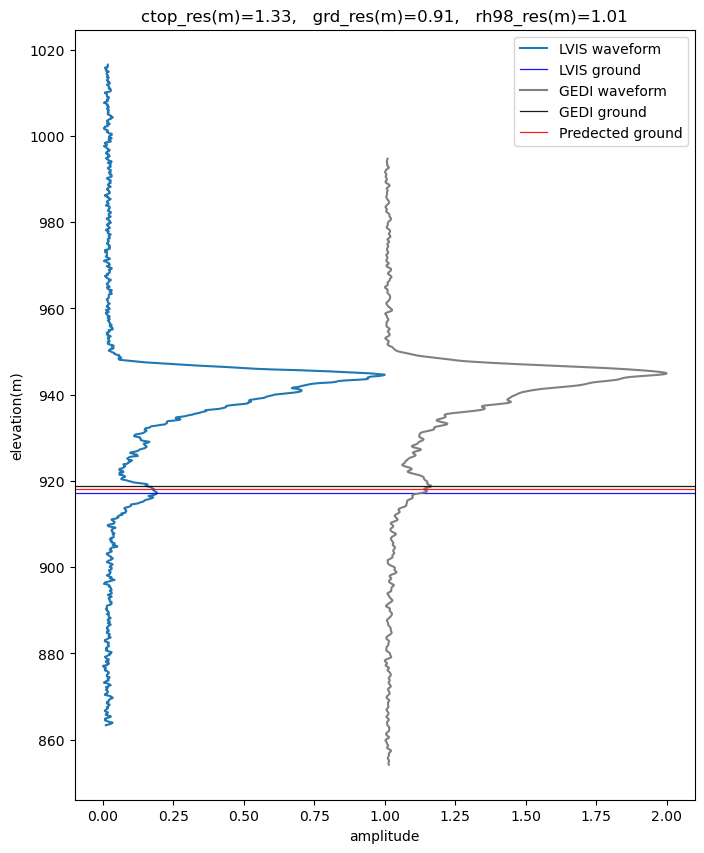

In [379]:
ind = 14820
plot_wf(ind, LVIS_df_masked, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked, shap_inds=[], line_elev=Y_data[ind])

In [380]:
x_train, x_test, x2_train, x2_test, y_train, y_test, inds_train, inds_test = train_test_split(X_data, X2_data, Y_data, data_inds, test_size=0.3, random_state=44)

print(x_train.shape, x_test.shape)
print(x2_train.shape, x2_test.shape)
print(y_train.shape, y_test.shape)
print(inds_train.shape, inds_test.shape)

(87210, 1420) (37376, 1420)
(87210, 6) (37376, 6)
(87210,) (37376,)
(87210,) (37376,)


# train model

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import multiprocessing

2024-09-05 14:59:32.628090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 14:59:32.628161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 14:59:32.811457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 14:59:33.268625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 14:59:53.120893: W tensorflow/compiler/tf2

In [54]:
def create_model(lidar_bins=1420, num_ancillary_features=1, use_ancillary=False):
    # Input layers
    lidar_input = Input(shape=(lidar_bins,), name='lidar_input')
    
    # LiDAR branch
    x = layers.Reshape((lidar_bins, 1))(lidar_input)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    lidar_features = layers.Dense(64, activation='relu', name='lidar_features')(x)
    
    if use_ancillary:
        # Ancillary data branch
        ancillary_input = Input(shape=(num_ancillary_features,), name='ancillary_input')
        y = layers.Dense(32, activation='relu')(ancillary_input)
        y = layers.Dense(32, activation='relu')(y)
        ancillary_features = layers.Dense(16, activation='relu', name='ancillary_features')(y)
        
        # Combine features
        combined = layers.concatenate([lidar_features, ancillary_features])
    else:
        combined = lidar_features
    
    # Joint layers
    z = layers.Dense(64, activation='relu')(combined)
    z = layers.Dense(32, activation='relu')(z)
    z = layers.Dropout(0.3)(z)  # Add dropout for regularization
    
    # Output layer: Changed to a single neuron with sigmoid activation
    output = layers.Dense(1, activation='linear', name='output')(z)
    
    # Create model
    if use_ancillary:
        model = Model(inputs=[lidar_input, ancillary_input], outputs=output)
    else:
        model = Model(inputs=lidar_input, outputs=output)
    
    return model

In [57]:
from tensorflow.keras.optimizers import Adam
model = create_model(lidar_bins=1420, num_ancillary_features=6, use_ancillary=False)

model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lidar_input (InputLayer)    [(None, 1420)]            0         
                                                                 
 reshape_2 (Reshape)         (None, 1420, 1)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 1418, 64)          256       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 709, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 707, 128)          24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 353, 128)          0         
 g1D)                                                      

In [69]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stopping = EarlyStopping(
#     monitor='val_loss',   # Monitor the validation loss
#     patience=5,           # Number of epochs with no improvement after which training will be stopped
#     verbose=1             # Output verbosity
# )

# model_checkpoint = ModelCheckpoint(
#     'models/best_model.h5',      # File path to save the best model
#     monitor='val_loss',   # Monitor the validation loss
#     save_best_only=True,  # Save only the best model based on the monitored quantity
#     verbose=1             # Output verbosity
# )

# # Fit the model
# history = model.fit(
#     x_train,
#     y_train,
#     epochs=30,
#     validation_data=(x_test, y_test),
#     use_multiprocessing=True,
#     workers=20,
#     shuffle=True,
#     callbacks=[early_stopping, model_checkpoint]
# )

In [107]:
from tensorflow.keras.models import load_model
best_model = load_model('models/new/best_model.h5')

pred_test = best_model.predict(x_test)
print('test')
print("RMSE:\n", np.sqrt(mean_squared_error(pred_test, y_test)))

pred_train = best_model.predict(x_train)
print('train')
print("RMSE:\n", np.sqrt(mean_squared_error(pred_train, y_train)))

5062/5062 [==============================] - 22s 4ms/step
test
RMSE:
 1.5525526369656995
11811/11811 [==============================] - 50s 4ms/step
train
RMSE:
 1.5267357319069152


In [391]:
from tensorflow.keras.models import load_model
best_model = load_model('models/new2/best_model.h5')

pred_test = best_model.predict(x_test)
print('test')
print("RMSE:\n", np.sqrt(mean_squared_error(pred_test, y_test)))

pred_train = best_model.predict(x_train)
print('train')
print("RMSE:\n", np.sqrt(mean_squared_error(pred_train, y_train)))

1168/1168 [==============================] - 5s 4ms/step
test
RMSE:
 3.386454759112445
2726/2726 [==============================] - 11s 4ms/step
train
RMSE:
 3.34589957614408


In [382]:
from tensorflow.keras.models import load_model
best_model = load_model('models/new2/best_model.h5')

pred_all = best_model.predict(X_data)
print('test')
print("RMSE:\n", np.sqrt(mean_squared_error(pred_all, Y_data)))

3894/3894 [==============================] - 18s 5ms/step
test
RMSE:
 3.3581176191452204


In [383]:
pred_grd_elev = GEDI_L1B_df_masked['geolocation/elevation_bin0'].values - pred_all.ravel()
np.sqrt(mean_squared_error(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values, pred_grd_elev))

2.8370340548423822

In [384]:
np.sqrt(mean_squared_error(pred_grd_elev, LVIS_df_masked['ZG'].values))

3.471502630577697

In [385]:
np.sqrt(mean_squared_error(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values, LVIS_df_masked['ZG'].values))

3.809037054414056

In [193]:
def plot_scatter(x_data, y_data, bins=200, limit=100, vmax=10):
    fig, ax = plt.subplots(figsize=(8, 8))
    cs = plt.hist2d(x_data, y_data, bins=bins, cmin=1, vmax=vmax, cmap='jet', range=[(0,100),(0,100)])
    # b, a = np.polyfit(x_data, xovers_2016['rh_98'], deg=1)
    # ax.axline((0, a), slope=b, color="black", linewidth=0.7, linestyle='--')
    
    r2 = np.corrcoef(x_data, y_data)[0, 1]**2
    rmse = np.sqrt(mean_squared_error(x_data, y_data))
    ax.set_title(f'R2={r2:.02f},   RMSE={rmse:.02f}m,   N={len(x_data)}')
    
    ax.set_xlabel('LVIS RH98 (m)')
    ax.set_ylabel('GEDI RH98 (m)')
    
    ax.set_aspect('equal')
    ax.axline((0, 0), slope=1, color="black", linewidth=0.7)
    ax.set_xlim(0, limit)
    ax.set_ylim(0, limit)
    
    inset_ax = inset_axes(ax,
                          width="2%",  # width of colorbar relative to parent plot
                          height="50%",  # height of colorbar relative to parent plot
                          loc='lower right',  # location of the colorbar
                          bbox_to_anchor=(-0.1, 0.05, 1, 1),  # Bounding box to anchor the colorbar
                          bbox_transform=ax.transAxes,
                          borderpad=0)
    
    colorbar = plt.colorbar(cax=inset_ax, shrink=0.5)
    colorbar.set_label('Density')
    plt.show()

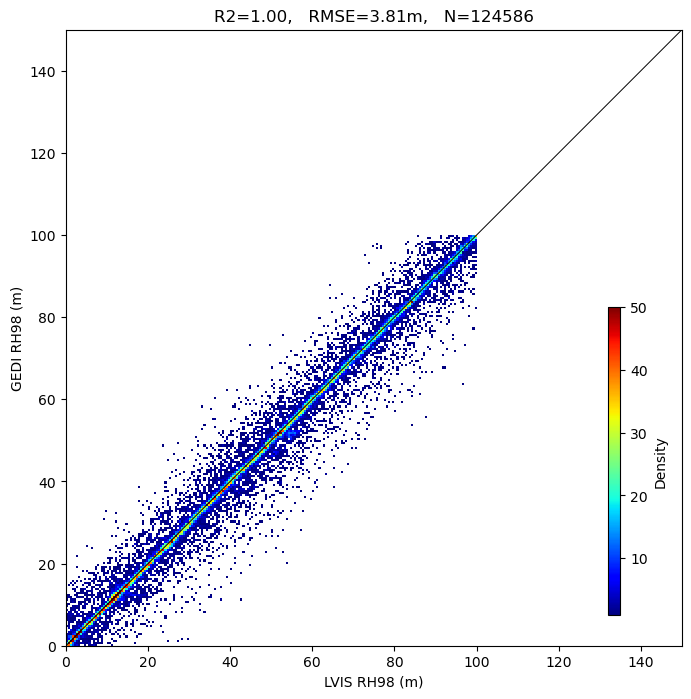

In [386]:
plot_scatter(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values, LVIS_df_masked['ZG'].values, bins=200, limit=150, vmax=50)

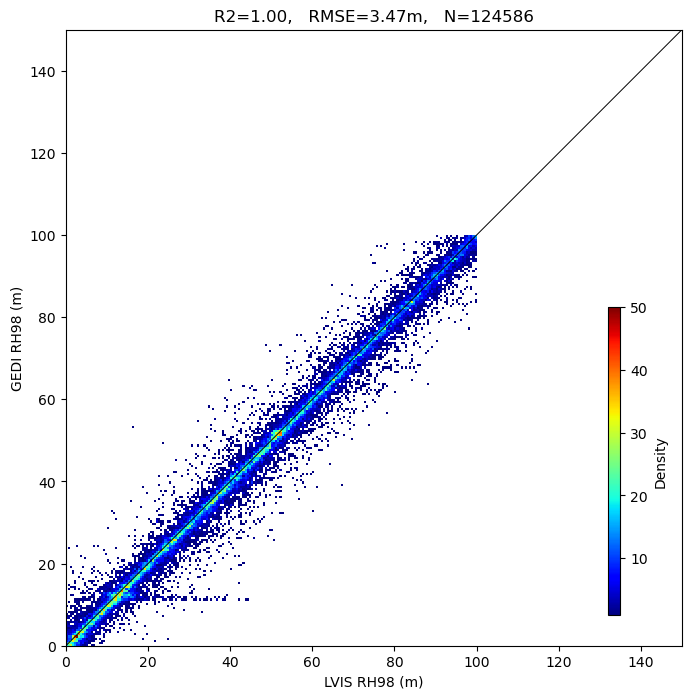

In [387]:
plot_scatter(pred_grd_elev, LVIS_df_masked['ZG'].values, bins=200, limit=150, vmax=50)

# calculate rmse

In [388]:
np.sqrt(mean_squared_error(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values[inds_test], LVIS_df_masked['ZG'].values[inds_test]))

3.765035804948759

In [389]:
test_grd_elev = GEDI_L1B_df_masked['geolocation/elevation_bin0'].values[inds_test] - y_test
np.sqrt(mean_squared_error(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values[inds_test], test_grd_elev))

3.665116293049948

In [392]:
pred_test_grd_elev = GEDI_L1B_df_masked['geolocation/elevation_bin0'].values[inds_test] - pred_test.ravel()
np.sqrt(mean_squared_error(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values[inds_test], pred_test_grd_elev))

2.8374656188267173

In [415]:
np.sqrt(mean_squared_error(pred_test_grd_elev, LVIS_df_masked['ZG'].values[inds_test]))

3.5034818091744317

In [393]:
np.sqrt(mean_squared_error(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values[inds_train], LVIS_df_masked['ZG'].values[inds_train]))

3.827740038647478

In [394]:
train_grd_elev = GEDI_L1B_df_masked['geolocation/elevation_bin0'].values[inds_train] - y_train
np.sqrt(mean_squared_error(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values[inds_train], train_grd_elev))

3.7276012727303436

In [395]:
pred_train_grd_elev = GEDI_L1B_df_masked['geolocation/elevation_bin0'].values[inds_train] - pred_train.ravel()
np.sqrt(mean_squared_error(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values[inds_train], pred_train_grd_elev))

2.8368490792499426

In [396]:
np.argsort(np.abs(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values[inds_test] - pred_test_grd_elev))[-65]

16311

gedi sn:  89870600200426224
lvis sn:  21632121
lvis lfid:  1659432322
gedi elev lowest mode:  377.7144


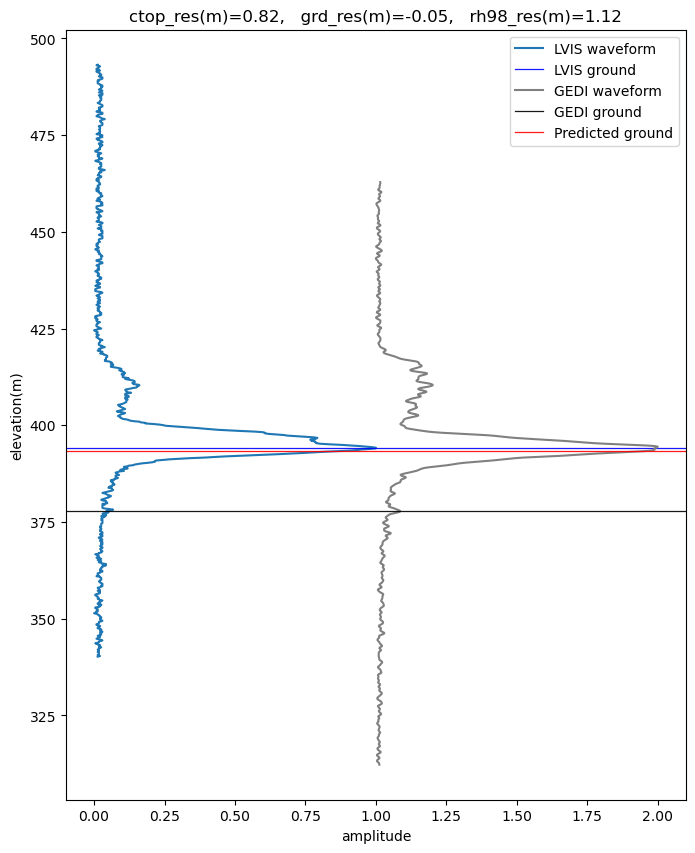

377.7144
394.0
393.3280211845413


In [414]:
ind = np.argsort(np.abs(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].values[inds_test] - pred_test_grd_elev))[-110]
plot_wf(inds_test[ind], LVIS_df_masked, GEDI_L2A_df_alg_masked, GEDI_L1B_df_masked, shap_inds=[], line_elev=pred_test[ind])
print(GEDI_L2A_df_alg_masked['geolocation/elev_lowestmode'].iloc[inds_test[ind]])
print(LVIS_df_masked['ZG'].iloc[inds_test[ind]])
print(pred_test_grd_elev[ind])

# ancillary

In [179]:
from tensorflow.keras.models import load_model
best_model = load_model('models/best_model_anc.h5')

pred_test = best_model.predict([x_test, x2_test])
print('test')
print("RMSE:\n", np.sqrt(mean_squared_error(pred_test, y_test)))

pred_train = best_model.predict([x_train, x2_train])
print('train')
print("RMSE:\n", np.sqrt(mean_squared_error(pred_train, y_train)))

5062/5062 [==============================] - 23s 5ms/step
test
RMSE:
 1.6325782618668998
11811/11811 [==============================] - 55s 5ms/step
train
RMSE:
 1.627821505084891
